In [98]:
import advanced_simulator_h5
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi.inference import SNPE
from torch.utils.data import DataLoader, Dataset
import h5py
import glob
import numpy as np
from advanced_simulator_h5 import reconstruct_distance_matrix
from sbi.neural_nets import posterior_nn
import os
from datetime import datetime
import random


# Funktion: Flatten und concat Beobachtungen zu 2D Tensor [B, FeatureDim]
def flatten_and_concat(gene_tensor, allele_tensor, distances_tensor, fitch_tensor):
    B = gene_tensor.shape[0]
    gene_flat = gene_tensor.view(B, -1)                    # [B, 1000]
    allele_flat = allele_tensor.view(B, -1)                # [B, 1000,1000 = 1,000,000]
    distances_flat = distances_tensor.view(B, -1)          # [B, 1,000,000]
    fitch_flat = fitch_tensor.view(B, -1)                  # [B, 1]
    combined = torch.cat([gene_flat, allele_flat, distances_flat, fitch_flat], dim=1)  # [B, 2,001,001]
    return combined


def unflatten_and_split(x: torch.Tensor, num_samples: int, multidimensional_scaling_dimensions: int) -> tuple:
    """
    Zerlegt einen flach kombinierten Tensor wieder in seine Einzelbestandteile:
    - gene presence/absence matrix
    - allele PCA matrix
    - distance matrix
    - fitch score

    Args:
        x: Tensor der Form (B, N), der alle Komponenten enthält.
        alleles_shape: Tuple (A0, A1) — Form der Allele und Distance-Matrix.

    Returns:
        Tuple aus:
        - gene_tensor: (B, 1, A1)
        - allele_tensor: (B, 1, A0, A1)
        - distance_tensor: (B, 1, A0, A1)
        - fitch_tensor: (B, 1)
    """
    B = x.shape[0]
    G = num_samples
    A0, A1 = num_samples, multidimensional_scaling_dimensions
    D0, D1 = num_samples, multidimensional_scaling_dimensions

    gene_len = G
    allele_len = A0 * A1
    distance_len = D0 * D1

    gene_flat = x[:, :gene_len].view(B, 1, G)

    allele_start = gene_len
    allele_end = allele_start + allele_len
    allele_flat = x[:, allele_start:allele_end].view(B, 1, A0, A1)

    distance_start = allele_end
    distance_end = distance_start + distance_len
    distance_flat = x[:, distance_start:distance_end].view(B, 1, D0, D1)

    fitch_flat = x[:, distance_end:].view(B, 1)

    return gene_flat, allele_flat, distance_flat, fitch_flat
    
class NeuralNetwork(nn.Module):
    def __init__(self, num_samples, multidimensional_scaling_dimensions):
        super().__init__()
        
        self.num_samples = num_samples
        self.multidimensional_scaling_dimensions = multidimensional_scaling_dimensions

        self.Softplus = nn.Softplus()

        self.conv1d = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=0)
        
        dummy_input = torch.zeros(1, 1, num_samples)  # B=1, C=1, L=num_samples
        conv1d_out_dim = self.conv1d(dummy_input).view(1, -1).shape[1]

        """
        self.pointwise_combine_allele_distance = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding = 0, stride = 1)
        
        dummy_input = torch.zeros(1, 1, num_samples, num_samples)
        out = self.min_max_avg_conv2d(dummy_input)
        conv2d_out_dim = self.pointwise_combine_allele_distance(out).view(1, -1).shape[1]

        total_input_dim = conv1d_out_dim + conv2d_out_dim + 1 

        """
        
        kernel = [[0, -1/4, 0],[-1/4, 1, -1/4],[0, -1/4, 0]]
        kernel_tensor = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.conv2dim = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_tensor.shape[-2:], bias=False)

        dummy_input = torch.zeros(1, 1, num_samples, num_samples)
        conv2d_out_dim = self.conv2dim(dummy_input).view(1, -1).shape[1]
        total_input_dim = conv1d_out_dim + conv2d_out_dim + 1 
        total_input_dim = conv2d_out_dim 

        with torch.no_grad():
            self.conv2dim.weight.copy_(kernel_tensor)
        self.conv2dim.weight.requires_grad = False  # Keine Optimierung

        self.fc = nn.Sequential(
            nn.Linear(total_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 50%
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 3)
        )
        
    def min_max_avg_conv2d(self, x, kernel_size=2, stride=1, padding=0):
        """
        x: Tensor mit Shape [B, C, H, W]
        Kernel: z.B. 3x3
        Output: Tensor mit Shape [B, C*3, H_out, W_out], wobei für jeden Kanal
                Minimum, Maximum, Average über das jeweilige Fenster berechnet werden.
        """
    
        B, C, H, W = x.shape
    
        # 1. Unfold: extrahiere alle Fenster als Spalten
        # Ergebnis: [B, C * kernel_size*kernel_size, L], L = Anzahl Fenster = H_out * W_out
        x_unfold = F.unfold(x, kernel_size=kernel_size, stride=stride, padding=padding)
        # Shape: [B, C * k*k, L]
    
        k = kernel_size * kernel_size
        L = x_unfold.shape[-1]
    
        # 2. reshape zu [B, C, k*k, L]
        x_unfold = x_unfold.view(B, C, k, L)
    
        # 3. min, max, avg entlang Dimension k (Fenstergröße)
        min_vals = x_unfold.min(dim=2)[0]   # [B, C, L]
        max_vals = x_unfold.max(dim=2)[0]   # [B, C, L]
        avg_vals = x_unfold.mean(dim=2)     # [B, C, L]
    
        # 4. Concatenate diese 3 Werte pro Kanal
        out = torch.cat([min_vals, max_vals, avg_vals], dim=1)  # [B, C*3, L]
    
        # 5. Fold zurück zu Bild: Größe (H_out, W_out)
        H_out = (H + 2*padding - kernel_size)//stride + 1
        W_out = (W + 2*padding - kernel_size)//stride + 1
    
        out = out.view(B, C*3, H_out, W_out)
        return self.Softplus(out)
        
    def forward(self, x):
        """
        x: shape [B, total_features]
        """
        B = x.shape[0]
        
        gene_flat, allele_flat, distance_flat, fitch_flat = unflatten_and_split(x, self.num_samples, self.multidimensional_scaling_dimensions)

        allele_flat = allele_flat.squeeze(1)     # [B, 100, 50]
        distance_flat = distance_flat.squeeze(1) # [B, 100, 50]
        
        allele_core_distance_list = []
        valid_mask_list = []
        
        for i in range(B):
            allele_processed = reconstruct_distance_matrix(
                allele_flat[i],  # shape [100, 50]
                gene_absence_presence=gene_flat[i].squeeze()  # ggf. anpassen
            )
            distance_processed = reconstruct_distance_matrix(
                distance_flat[i],  # shape [100, 50]
                gene_absence_presence=None
            )
            gene_present_vector = (gene_flat[0].squeeze() == 1)
            mean_core_distance = np.mean(distance_processed[np.ix_(gene_present_vector, gene_present_vector)])
            mean_allel_distance = np.mean(allele_processed[np.ix_(gene_present_vector, gene_present_vector)])
            if mean_allel_distance > 0:
                allele_processed[np.ix_(gene_present_vector, gene_present_vector)] = allele_processed[np.ix_(gene_present_vector, gene_present_vector)] / mean_allel_distance * mean_core_distance

            allele_core_distance = allele_processed - distance_processed
            allele_core_distance[~gene_present_vector, :] = -1
            allele_core_distance[:, ~gene_present_vector] = -1

            valid_mask = (gene_present_vector[:, None] & gene_present_vector[None, :]).float()
            
            allele_core_distance_list.append(torch.tensor(np.abs(allele_core_distance), dtype=torch.float32))
            valid_mask_list.append(torch.tensor(valid_mask, dtype=torch.float32))
            
        # Stapeln zu Tensor zurück
        allele_core_distance_tensor = torch.stack(allele_core_distance_list)    # [B, H, W]
        valid_mask_tensor = torch.stack(valid_mask_list)

        network_input = torch.stack([allele_core_distance_tensor, valid_mask_tensor], dim=1)
        
        #allele_core_distance_processed = allele_core_distance_processed.unsqueeze(1)    
        
        # Jetzt kannst du Conv2d Layer darauf anwenden
        #gene_flat_conv_out = self.conv1d(gene_flat)

        """
        allele_core_distance_conv_out = self.min_max_avg_conv2d(allele_core_distance_processed)

        allele_distance_combined_conv_out = self.pointwise_combine_allele_distance(allele_core_distance_conv_out)
        """
        """
        allele_distance_combined_conv_out = self.conv2dim(allele_core_distance_processed)
        
        # --- Kombination

        #parts = [gene_flat_conv_out, allele_distance_combined_conv_out, fitch_flat]
        parts = [allele_distance_combined_conv_out]

        parts = [p.view(p.size(0), -1) for p in parts]
        
        x = torch.cat(parts, dim=-1)
        
        return self.fc(x)
        """

        x = self.encoder(network_input)
        x = self.mlp(x)
        return x

class H5SimulationDataset(Dataset):
    def __init__(self, files_or_dir):
        if isinstance(files_or_dir, str):  # ein Pfad
            self.files = sorted(glob.glob(f"{files_or_dir}/*.h5"))
        elif isinstance(files_or_dir, list):  # eine Liste von Dateipfaden
            self.files = sorted(files_or_dir)
        else:
            raise ValueError("Expected str (directory) or list (files) for files_or_dir.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        with h5py.File(file, "r") as f:
            grp = f["results"]
            hgt_rate = grp.attrs["hgt_rate"]
            rho = grp.attrs["rho"]
            gene_number_hgt_events_passed = grp.attrs["gene_number_hgt_events_passed"]
            fitch_score = grp.attrs["fitch_score"]
            
            gene_absence_presence = grp["matrix"][:]
            distance_matrix = grp["distance_matrix"][:]
            #reconstructed_distance_matrix = reconstruct_distance_matrix(distance_matrix, gene_absence_presence=None)
            reconstructed_distance_matrix = distance_matrix
            
            # PCA-Matrizen
            alleles_list_pca = []
            pca_keys = [key for key in grp.keys() if key.startswith("alleles_list_pca_")]
            pca_keys.sort()
            for key in pca_keys:
                alleles_pca_raw = grp[key][:]
                idx = int(key.split("_")[-1])
                """
                alleles_pca_reconstructed = reconstruct_distance_matrix(
                        alleles_pca_raw,
                        gene_absence_presence = gene_absence_presence[idx]
                    )
                """
                alleles_pca_reconstructed = alleles_pca_raw
                alleles_list_pca.append(alleles_pca_reconstructed)

        # Als Torch-Tensoren
        gene_absence_presence = torch.tensor(gene_absence_presence, dtype=torch.float32)
        distance_matrix = torch.tensor(reconstructed_distance_matrix, dtype=torch.float32)
        alleles_list_pca = torch.tensor(np.stack(alleles_list_pca), dtype=torch.float32)
        fitch_score = torch.tensor(fitch_score, dtype=torch.float32)
        gene_number_hgt_events_passed = float(gene_number_hgt_events_passed)

        theta = torch.tensor([hgt_rate, rho, gene_number_hgt_events_passed], dtype=torch.float32)
        #theta = torch.tensor([gene_number_hgt_events_passed], dtype=torch.float32)

        return {
            "gene_absence_presence": gene_absence_presence.float(),
            "alleles_list_pca": alleles_list_pca.float(),
            "distance_matrix": distance_matrix.float(),
            "fitch_score": fitch_score.clone().detach().float(),
            "theta": theta
        }


In [99]:
# === Parameter ===
output_dir = r"C:\Users\uhewm\Desktop\SBI_Data\simulation_chunks"

# alle Dateien laden
all_files = sorted(glob.glob(os.path.join(output_dir, "*.h5")))
sampling_fraction = 0.8   # z.B. 10% der Daten
n_total = len(all_files)
n_files = max(1, int(n_total * sampling_fraction))
sampled_files = random.sample(all_files, n_files)

print(f"Von {n_total} Dateien werden {n_files} verwendet.")

hgt_rate_max = 20 # Maximum hgt rate
hgt_rate_min = 0 # Minimum hgt rate

rho_max = 10 # Maximum gene loss rate
rho_min = 0 # Minimum gene loss rate

num_samples = 100
multidimensional_scaling_dimensions = 100

# Dein Prior
prior = utils.BoxUniform(
    low=torch.tensor([hgt_rate_min, rho_min, 0.0]),
    high=torch.tensor([hgt_rate_max, rho_max, 1500.0])  # je nach Parameter
)

# === DEIN EMBEDDING ===
embedding_net = NeuralNetwork(num_samples=num_samples, multidimensional_scaling_dimensions=multidimensional_scaling_dimensions)

# === INITIALISIERE SNPE ===
neural_posterior = posterior_nn(
    model="maf",
    embedding_net=embedding_net,
    hidden_features=64,
    num_transforms=4
)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

dataset = H5SimulationDataset(sampled_files)
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

x_buffer, theta_buffer = [], []

for batch in loader:
    gene_absence_presence = batch["gene_absence_presence"]
    alleles_list_pca = batch["alleles_list_pca"]
    distance_matrix = batch["distance_matrix"]
    fitch_score = batch["fitch_score"]
    theta = batch["theta"]

    x = flatten_and_concat(
        gene_absence_presence,
        alleles_list_pca,
        distance_matrix,
        fitch_score.unsqueeze(1)
    )

    x_buffer.append(x)
    theta_buffer.append(theta)

# Stapelweise zusammenführen
x_all = torch.cat(x_buffer, dim=0)
theta_all = torch.cat(theta_buffer, dim=0)

# Simulationen anhängen
inference.append_simulations(theta_all, x_all)

# === TRAINIEREN UND POSTERIOR ERSTELLEN ===
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

Von 16208 Dateien werden 12966 verwendet.


C:\Users\uhewm\AppData\Local\Temp\ipykernel_3452\4156415425.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gene_number_hgt_events_passed = float(gene_number_hgt_events_passed)
C:\Users\uhewm\AppData\Local\Temp\ipykernel_3452\4156415425.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_mask_list.append(torch.tensor(valid_mask, dtype=torch.float32))


 Neural network successfully converged after 83 epochs.

In [100]:
import random
import torch
import matplotlib.pyplot as plt

# Ergebnisse sammeln
true_hgt = []
true_rho = []
true_hgt_events = []

pred_mean_hgt = []
pred_mean_rho = []
pred_mean_hgt_events = []

abs_diff_hgt = []
abs_diff_rho = []
abs_diff_hgt_events = []

gene_freq_colors = []
true_fitch_scores = []

# wenn du aus dem gelernten Posterior abfragen willst:
# typischerweise in einem separaten Notebook/Skript
# nach dem Training

# 5000 Stichproben indices zufällig auswählen
indices = random.sample(range(len(dataset)), k=min(5000, len(dataset)))

for idx in indices:
    # hole einen einzelnen Eintrag
    item = dataset[idx]
    
    # flatten & concat
    x_test = flatten_and_concat(
        item["gene_absence_presence"].unsqueeze(0),   # B=1
        item["alleles_list_pca"].unsqueeze(0),
        item["distance_matrix"].unsqueeze(0).unsqueeze(1),
        item["fitch_score"].view(1, 1)
    )
    
    # ground truth
    true_hgt.append(item["theta"][0].item())
    true_rho.append(item["theta"][1].item())
    true_hgt_events.append(item["theta"][2].item())
    true_fitch_scores.append(item["fitch_score"].item())
    
    # sample aus posterior
    samples = posterior.sample((20,), x=x_test)
    
    # mittelwert pro Parameter
    mean_hgt = samples[:, 0].mean().item()
    mean_rho = samples[:, 1].mean().item()
    mean_hgt_events = samples[:, 2].mean().item()
    
    pred_mean_hgt.append(mean_hgt)
    pred_mean_rho.append(mean_rho)
    pred_mean_hgt_events.append(mean_hgt_events)
    
    abs_diff_hgt.append(abs(mean_hgt - true_hgt[-1]))
    abs_diff_rho.append(abs(mean_rho - true_rho[-1]))
    abs_diff_hgt_events.append(abs(mean_hgt_events - true_hgt_events[-1]))

    gene_freq = item["gene_absence_presence"].sum() / item["gene_absence_presence"].numel()
    gene_freq_colors.append(gene_freq.item())

# Konvertiere Listen für sauberes Plotting
true_hgt = torch.tensor(true_hgt)
true_rho = torch.tensor(true_rho)
true_hgt_events = torch.tensor(true_hgt_events)

pred_mean_hgt = torch.tensor(pred_mean_hgt)
pred_mean_rho = torch.tensor(pred_mean_rho)
pred_mean_hgt_events = torch.tensor(pred_mean_hgt_events)

colors = torch.tensor(gene_freq_colors)

C:\Users\uhewm\AppData\Local\Temp\ipykernel_3452\4156415425.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gene_number_hgt_events_passed = float(gene_number_hgt_events_passed)


Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\uhewm\AppData\Local\Temp\ipykernel_3452\4156415425.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_mask_list.append(torch.tensor(valid_mask, dtype=torch.float32))


Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

Drawing 20 posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

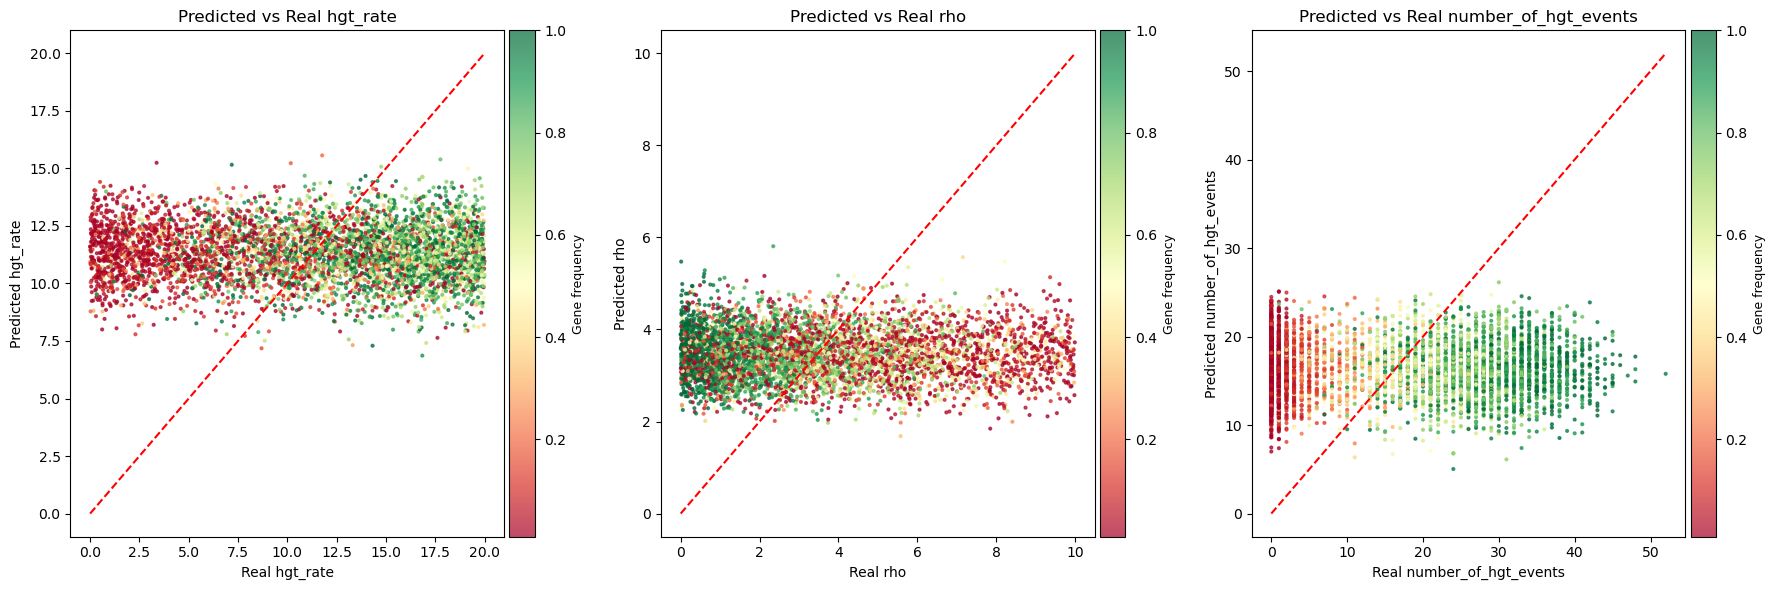

In [101]:
# === Plotten ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. hgt_rate
sc0 = axs[0].scatter(
    true_hgt,
    pred_mean_hgt,
    c=colors,
    cmap="RdYlGn",
    alpha=0.7,
    s=4
)
axs[0].plot(
    [hgt_rate_min, hgt_rate_max],
    [hgt_rate_min, hgt_rate_max],
    color="red", linestyle="--"
)
axs[0].set_xlabel("Real hgt_rate")
axs[0].set_ylabel("Predicted hgt_rate")
axs[0].set_title("Predicted vs Real hgt_rate")
cbar0 = fig.colorbar(sc0, ax=axs[0], orientation='vertical', pad=0.01)
cbar0.set_label("Gene frequency", fontsize=9)

# 2. rho
sc1 = axs[1].scatter(
    true_rho,
    pred_mean_rho,
    c=colors,
    cmap="RdYlGn",
    alpha=0.7,
    s=4
)
axs[1].plot(
    [rho_min, rho_max],
    [rho_min, rho_max],
    color="red", linestyle="--"
)
axs[1].set_xlabel("Real rho")
axs[1].set_ylabel("Predicted rho")
axs[1].set_title("Predicted vs Real rho")
cbar1 = fig.colorbar(sc1, ax=axs[1], orientation='vertical', pad=0.01)
cbar1.set_label("Gene frequency", fontsize=9)

# 3. number_of_hgt_events
sc2 = axs[2].scatter(
    true_hgt_events,
    pred_mean_hgt_events,
    c=colors,
    cmap="RdYlGn",
    alpha=0.7,
    s=4
)
axs[2].plot(
    [true_hgt_events.min(), true_hgt_events.max()],
    [true_hgt_events.min(), true_hgt_events.max()],
    color="red", linestyle="--"
)
axs[2].set_xlabel("Real number_of_hgt_events")
axs[2].set_ylabel("Predicted number_of_hgt_events")
axs[2].set_title("Predicted vs Real number_of_hgt_events")
cbar2 = fig.colorbar(sc2, ax=axs[2], orientation='vertical', pad=0.01)
cbar2.set_label("Gene frequency", fontsize=9)

plt.tight_layout()

save_dir = r"C:\Users\uhewm\Desktop\SBI_Data\plots"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"posterior_plot_{timestamp}.png"
save_path = os.path.join(save_dir, filename)

# Speichern
plt.savefig(save_path, dpi=300)
plt.show()

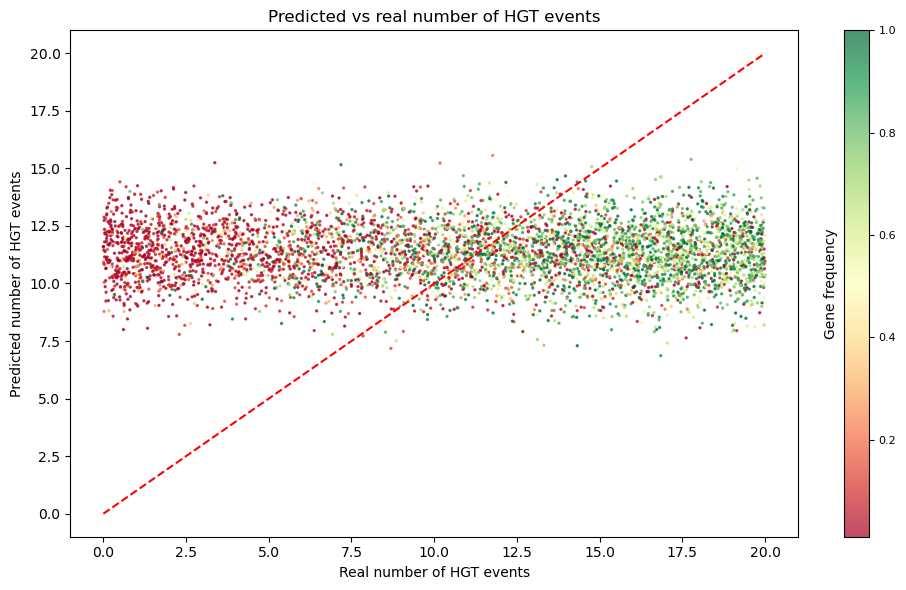

In [102]:
plt.figure(figsize=(10, 6))

# Scatter-Plot mit Farbskala von rot nach grün
sc = plt.scatter(
    true_hgt,
    pred_mean_hgt,
    c=colors,
    cmap='RdYlGn',      # Rot → Gelb → Grün
    alpha=0.7,
    s=2
)

# Diagonale
plt.plot(
    [min(true_hgt), max(true_hgt)],
    [min(true_hgt), max(true_hgt)],
    color="red", linestyle="--"
)

plt.xlabel("Real number of HGT events")
plt.ylabel("Predicted number of HGT events")
plt.title("Predicted vs real number of HGT events")

# Farbleiste als Legende oben rechts
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05)
cbar.set_label("Gene frequency", fontsize=10)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

In [25]:
true_hgt = []
true_rho = []
true_hgt_events = []

pred_mean_hgt = []
pred_mean_rho = []
pred_mean_hgt_events = []

abs_diff_hgt = []
abs_diff_rho = []
abs_diff_hgt_events = []

gene_freq_colors = []
true_fitch_scores = []

item = dataset[idx]

# flatten & concat
x_test = flatten_and_concat(
    item["gene_absence_presence"].unsqueeze(0),   # B=1
    item["alleles_list_pca"].unsqueeze(0),
    item["distance_matrix"].unsqueeze(0).unsqueeze(1),
    item["fitch_score"].view(1, 1)
)

# ground truth
true_hgt.append(item["theta"][0].item())
true_rho.append(item["theta"][1].item())
true_hgt_events.append(item["theta"][2].item())
true_fitch_scores.append(item["fitch_score"].item())

print(true_hgt_events)

[0.0]


C:\Users\uhewm\AppData\Local\Temp\ipykernel_3992\1687902006.py:257: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gene_number_hgt_events_passed = float(gene_number_hgt_events_passed)


In [150]:
sum(gene_absence_presence[0]) < 50 or hgt_events < 10

False

C:\Users\uhewm\AppData\Local\Temp\ipykernel_3452\4156415425.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gene_number_hgt_events_passed = float(gene_number_hgt_events_passed)


idx 281


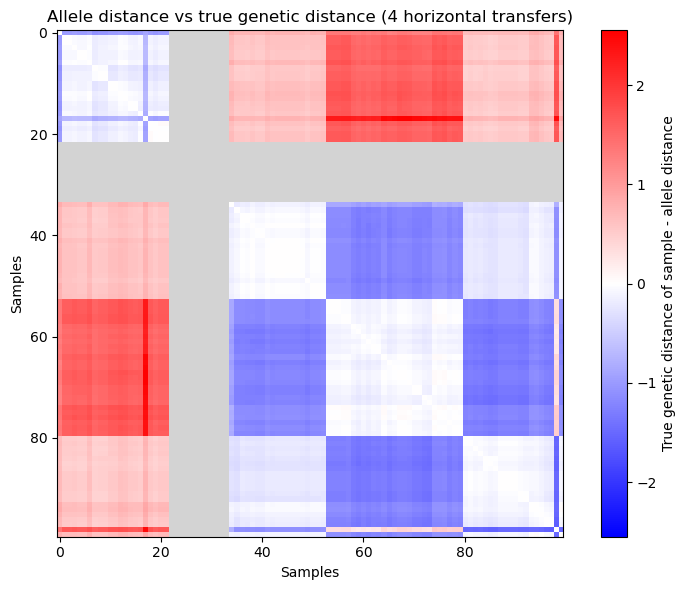

In [157]:
#k = 100
k = k+1
batch = dataset[k] # 11, 

gene_absence_presence = batch["gene_absence_presence"]
alleles_list_pca = batch["alleles_list_pca"]
distance_matrix = batch["distance_matrix"]
fitch_score = batch["fitch_score"]
theta = batch["theta"]
hgt_events = batch['theta'][2].item()

while sum(gene_absence_presence[0]) < 50 or hgt_events > 5: 
    batch = dataset[k] # 11, 
    
    gene_absence_presence = batch["gene_absence_presence"]
    alleles_list_pca = batch["alleles_list_pca"]
    distance_matrix = batch["distance_matrix"]
    fitch_score = batch["fitch_score"]
    theta = batch["theta"]
    hgt_events = batch['theta'][2].item()
    k = k+1

allele_processed = reconstruct_distance_matrix(alleles_list_pca[0],  gene_absence_presence=gene_absence_presence[0])
distance_processed = reconstruct_distance_matrix(distance_matrix, gene_absence_presence=None)

gene_present_vector = (gene_absence_presence[0].squeeze() == 1)
mean_core_distance = np.mean(distance_processed[np.ix_(gene_present_vector, gene_present_vector)])
mean_allel_distance = np.mean(allele_processed[np.ix_(gene_present_vector, gene_present_vector)])
if mean_allel_distance > 0:
    allele_processed[np.ix_(gene_present_vector, gene_present_vector)] = allele_processed[np.ix_(gene_present_vector, gene_present_vector)] / mean_allel_distance * mean_core_distance

difference_matrix = distance_processed - allele_processed
difference_matrix[~gene_present_vector, :] = np.nan
difference_matrix[: , ~gene_present_vector] = np.nan

import matplotlib.pyplot as plt
import numpy as np

print("idx", k)
# Stelle sicher, dass difference_matrix eine NumPy-Matrix ist
matrix = difference_matrix  # falls es noch ein Tensor ist

cmap = plt.get_cmap("bwr").copy()  # Alternativen: "coolwarm", "seismic", "bwr"
cmap.set_bad(color='lightgray')     # für np.nan

# Wertebereich symmetrisch setzen (z. B. -0.2 bis 0.2)
abs_max = np.nanmax(difference_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(difference_matrix, cmap=cmap, vmin=-abs_max, vmax=abs_max)
plt.colorbar(label="True genetic distance of sample - allele distance")
plt.title(f"Allele distance vs true genetic distance ({int(hgt_events)} horizontal transfers)")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

In [68]:
hgt_events

tensor([36.])